## Introduction

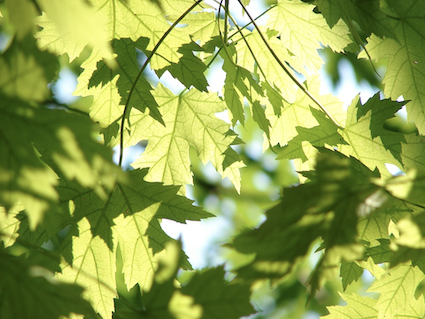




<center>
The Problem is to diagnose plant diseases solely based on leaf images. 
The categories include "healthy", "scab", "rust", and "multiple diseases". 

Solving this problem is important because diagnosing plant diseases early can save tonnes of agricultural produce every year. 
This will benefit not only the general population by reducing hunger, but also the farmers by ensuring they get the harvest they deserve.
</center>

<br>
<font color="red" size=3>Please upvote this kernel if you like it.:)</font>

### 1. Imports

In [ ]:
!pip install -q efficientnet

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
import efficientnet.tfkeras as efn
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

### 2. Reading Data

In [ ]:
IMAGE_PATH = "../input/plant-pathology-2020-fgvc7/images/"
TRAIN_PATH = "../input/plant-pathology-2020-fgvc7/train.csv"

train_data = pd.read_csv(TRAIN_PATH)

display(train_data.sample(3))

### 3. Loading Train images samples for exploration

In [ ]:
def load_image(image_id):
    file_path = image_id + '.jpg'
    image = cv2.imread(IMAGE_PATH + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data['image_id'][:200].progress_apply(load_image)

In [ ]:
fig = px.imshow(cv2.resize(train_images[0],(200, 150)))
fig.update_layout(
    margin=dict(l=25, r=20, t=20, b=20),
)
fig.show()

### Observation:

1. After hovering over the image pixels, we found that the healthy part(Green) have low blue values whereas the defective parts (Brown) have high values of blue channel
        **The blue channel may be the key to detecting diseases in plants**.

### R,G & B Channels

In [ ]:
red_values = [np.mean(train_images[idx][:,:,0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:,:,1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:,:,2]) for idx in range(len(train_images))]

# All Channels
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]

In [ ]:
fig = ff.create_distplot([values], group_labels=['Channels'], colors=['#868686'])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of all channel values")
fig.show()

The mean values of all the channels are dense at around 105

In [ ]:
fig = ff.create_distplot([red_values], group_labels=['Red'], colors=['#C70404'])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of Red channel values")
fig.show()

In [ ]:
fig = ff.create_distplot([green_values], group_labels=['Green'], colors=['#048F58'])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of Green channel values")
fig.show()

In [ ]:
fig = ff.create_distplot([blue_values], group_labels=['Blue'], colors=['#0479C7'])
fig.update_layout(showlegend=False, template="simple_white")
fig.update_layout(title_text="Distribution of Blue channel values")
fig.show()

In [ ]:
fig = go.Figure()

for idx, values in enumerate([red_values, green_values, blue_values]):
    if idx == 0:
        color = 'Red'
    if idx == 1:
        color = 'Green'
    if idx == 2:
        color = 'Blue'
    
    fig.add_trace(go.Box(x=[color]*len(values), y=values, name=color, marker=dict(color=color.lower())))

fig.update_layout(yaxis_title = 'Channels', 
                  xaxis_title = 'Mean Value', 
                  title='Mean Value vs Color Channel',
                  template='simple_white')

In [ ]:
fig = ff.create_distplot([red_values, green_values, blue_values], 
                         group_labels=['Red','Green','Blue'],
                         colors=['#C70404','#048F58','#0479C7']
                        )
fig.update_layout(title_text="Distribution of Different channel values", template='simple_white')

### Observations:
1. From above plots it is clear that the Green channel has higher values followed by red and Blue
2. The distribution of blue channel is close to Normal distribution.
3. The red channel has +ve Skew whereas the Green channel has -ve Skew.

### Function to display Leaf samples of different types

In [ ]:
def display_leaves(condition):
    # Assign a filter condition for querying the image data
    if condition == 'healthy':
        query_filter = 'healthy == 1'
    if condition == 'multiple_diseases':
        query_filter = 'multiple_diseases == 1'
    if condition == 'rust':
        query_filter = 'rust == 1'
    if condition == 'scab':
        query_filter = 'scab == 1'
    
    # Fetch the indexes from train_data based on condition
    image_index = train_data.query(query_filter)[:9].index
    
    # Create a list of images based on above indexes fetched 
    image_data = [train_images.loc[idx] for idx in image_index]
    
    cols = 3
    rows = 3
    
    fig = plt.figure(figsize=(15,10))
    
    for idx in range(cols * rows):     
        ax = fig.add_subplot(rows, cols, idx+1)
        ax.imshow(image_data[idx])
        _ = ax.axis('off')
    
    plt.show()

### i. Healthy

In [ ]:
display_leaves('healthy')

### ii. Rust

In [ ]:
display_leaves('rust')

### iii. Scab

In [ ]:
display_leaves('scab')

### iv. Multiple Diseases

In [ ]:
display_leaves('multiple_diseases')

### Different Types of Leaves

In [ ]:
fig = px.parallel_categories(train_data[["healthy", "scab", "rust", "multiple_diseases"]], 
                             color="healthy", color_continuous_scale=['#FB8729','#DD6605','#03811C','#027219'])

fig.update_layout(width=900, height=400, title= {'text': "Parallel categories plot of targets",
                                                'y':0.95,'x':0.5,
                                                'xanchor': 'center','yanchor': 'top'},
                 margin = dict(l=25, r=10, t=100, b=70))

### Observations:
1. Healthy leaves are almost 1/3rd of unhealthy leaves
2. Less than 40% of the leaves that are not suffering from SCAB are healthy, Similar is the case for Rust
3. There are very few Leaves that are suffering from multiple diseases.

In [ ]:
fig = go.Figure(
                [go.Pie(labels=train_data.columns[1:], 
                        values=train_data.iloc[:, 1:].sum().values,
                        marker=dict(colors=['#026416','#C73104','#C05209','#6F2F05']))
                ])

fig.update_layout(width=900, height=400, title= {'text': "Diseases",
                                                'y':0.95,'x':0.43,
                                                'xanchor': 'center','yanchor': 'top'},
                 margin = dict(l=50, r=10, t=50, b=30))


### 4. Configuring TPU

* TPUs are network-connected accelerators and you must first locate them on the network. This is what TPUClusterResolver() does.

* Two additional lines of boilerplate and you can define a TPUStrategy. This object contains the necessary distributed training code that will work on TPUs with their 8 compute cores

* Batch size, learning rate
    
    To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core           (ex:      batch size of 128*8=1024 for a TPU with 8 cores).
            BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
* tf.data.Dataset and TFRecords
    
    Because TPUs are very fast, many models ported to TPU end up with a data bottleneck. The TPU is sitting             idle, waiting for data for the most part of each training epoch. TPUs read training data exclusively from           GCS (Google Cloud Storage). And GCS can sustain a pretty large throughput if it is continuously streaming           from multiple files in parallel.
            

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)


# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)


BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_PATH = KaggleDatasets().get_gcs_path()

### 4. Image Processing

In [ ]:
# Google Cloud Storage Path for the kaggle datasets
GCS_PATH = KaggleDatasets().get_gcs_path()

def generate_path(image_id):
    return  GCS_PATH + '/images/' + image_id + '.jpg'

def decode_image(filename, label):
    image_size = (512,512)
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    return image, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    return image, label

### Training and Validation split

In [ ]:
from sklearn.model_selection import train_test_split

train_labels = np.float32(train_data.iloc[:,1:].values)
train_path = train_data['image_id'].apply(generate_path).values

train_path, valid_path, train_labels, valid_labels = \
            train_test_split(train_path, train_labels, test_size = 0.2, random_state=123)

### Creating Train and Validation TF dataset

#### Parameters definition:
    
    1. Shuffle : the file names will be shuffled randomly
    
    2. Repeat: Repeats the dataset so each original value is seen multiple times , since we are 
               randomly augmenting(flipping) our images
    
    3. Prefetch : This allows later elements to be prepared while the current element is being processed. 
                  This often improves latency and throughput, at the cost of using additional memory to store 
                  prefetched elements.
    
    4. num_parallel_calls : tf.data.experimental.AUTOTUNE is used, then the number of parallel calls 
                            is set dynamically based on available CPU.

In [ ]:
image_id = train_data['image_id'].values
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
        tf.data.Dataset\
        .from_tensor_slices((train_path, train_labels))\
        .map(decode_image, num_parallel_calls=AUTO)\
        .map(augment_image, num_parallel_calls=AUTO)\
        .repeat()\
        .shuffle(512)\
        .batch(BATCH_SIZE)\
        .prefetch(AUTO)\
        )

valid_dataset = (
    tf.data.Dataset\
    .from_tensor_slices((valid_path, valid_labels))\
    .map(decode_image, num_parallel_calls=AUTO)\
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

### Modelling with DenseNet

In [ ]:
with strategy.scope():
    model = tf.keras.models.Sequential()

    model.add(DenseNet121(
                     input_shape=(512,512,3),
                     weights = 'imagenet',
                     include_top=False))

    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dense(train_labels.shape[1],
                                   activation='softmax'))

    model.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])


### Model Architecture

In [ ]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

In [ ]:
# learning rate schedule
"""
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
"""

def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
callbacks_list = [lr_schedule]
STEPS_PER_EPOCH = train_labels.shape[0]//BATCH_SIZE

### Training the DenseNet Model

In [ ]:
history = model.fit(train_dataset,
                    epochs = 20,
                    callbacks = callbacks_list,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_data = valid_dataset)

In [ ]:
EPOCHS = 20
def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss vs. Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy vs. Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [ ]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

### Animation (click ▶️)

In [ ]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

### Sample predictions

Let's visualize some sample predictions made by the DenseNet model. The <font color="red">red</font> bars represent the model's prediction (maximum probability), the <font color="green">green</font> represent the ground truth (label), and the rest of the bars are <font color="blue">blue</font>. When the model predicts correctly, the prediction bar is <font color="green">green</font>.

In [ ]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model.layers[2](model.layers[1](model.layers[0](process(img)))).numpy()[0]

fig = make_subplots(rows=4, cols=2)
preds = predict(train_images[2])

colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Scab"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Multiple diseases"

colors[pred] = px.colors.qualitative.Plotly[1]
colors["Healthy"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=1200, width=800, title_text="DenseNet Predictions", showlegend=False)

preds = predict(train_images[0])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Multiple diseases"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=2, col=2)

preds = predict(train_images[3])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Rust"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=3, col=2)

preds = predict(train_images[1])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Scab"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=4, col=2)

fig.update_layout(template="plotly_white")

### EfficientNet


     EfficientNet is another popular (more recent) CNN-based ImageNet model which achieved the SOTA on several image-based tasks in 2019. 
     EfficientNet performs model scaling in an innovative way to achieve excellent accuracy with significantly fewer parameters. 
     It achieves the same if not greater accuracy than ResNet and DenseNet with a mcuh shallower architecture. 
     Now let us train EfficientNet on leaf images and evaluate its performance.

In [ ]:
with strategy.scope():
    model = tf.keras.Sequential([efn.EfficientNetB7(input_shape=(512, 512, 3),
                                                    weights='imagenet',
                                                    include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
    
    
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])

### Model Architecture

In [ ]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

### Training EfficientNet Model

In [ ]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

In [ ]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

### Animation (click ▶️)

In [ ]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

### Sample predictions

Let's visualize some sample predictions made by the EfficentNet model. The <font color="red">red</font> bars represent the model's prediction (maximum probability), the <font color="green">green</font> represent the ground truth (label), and the rest of the bars are <font color="blue">blue</font>. When the model predicts correctly, the prediction bar is <font color="green">green</font>.

In [ ]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model.layers[2](model.layers[1](model.layers[0](process(img)))).numpy()[0]

fig = make_subplots(rows=4, cols=2)
preds = predict(train_images[2])

colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Scab"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Multiple diseases"

colors[pred] = px.colors.qualitative.Plotly[1]
colors["Healthy"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=1200, width=800, title_text="EfficientNet Predictions", showlegend=False)

preds = predict(train_images[0])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Multiple diseases"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=2, col=2)

preds = predict(train_images[3])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Rust"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=3, col=2)

preds = predict(train_images[1])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Scab"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=4, col=2)
fig.update_layout(template="plotly_white")

### EfficientNet NoisyStudent 

    EfficientNet NoisyStudent, released in 2020, is based on EfficientNet and uses semi-supervised learning on noisy images to learn rich visual representation. 
    It outperformed EfficientNet on several tasks. 
    Now let us train EfficientNet NoisyStudent on leaf images and evaluate its performance.

In [ ]:
with strategy.scope():
    model = tf.keras.Sequential([efn.EfficientNetB7(input_shape=(512, 512, 3),
                                                    weights='noisy-student',
                                                    include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')])
    
    
        
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])

### Model Architecture

In [ ]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

### Training EfficientNet NoisyStudent

In [ ]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

In [ ]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [ ]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

### Sample predictions

Let's visualize some sample predictions made by the EfficentNet model. The <font color="red">red</font> bars represent the model's prediction (maximum probability), the <font color="green">green</font> represent the ground truth (label), and the rest of the bars are <font color="blue">blue</font>. When the model predicts correctly, the prediction bar is <font color="green">green</font>.

In [ ]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model.layers[2](model.layers[1](model.layers[0](process(img)))).numpy()[0]

fig = make_subplots(rows=4, cols=2)
preds = predict(train_images[2])

colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Scab"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Multiple diseases"

colors[pred] = px.colors.qualitative.Plotly[1]
colors["Healthy"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=1200, width=800, title_text="EfficientNet NoisyStudent Predictions", showlegend=False)

preds = predict(train_images[0])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Multiple diseases"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=2, col=2)

preds = predict(train_images[3])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Rust"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=3, col=2)

preds = predict(train_images[1])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Scab"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=4, col=2)
fig.update_layout(template="plotly_white")